## Evaluation: Max. supported user request rate
* Generate measurements with OMNeT++
* Convert them to csv using `scavetool x omnet-test/results/*.vec -o eval/measurements/max_rate.csv`
* Read and analyze using Python

For more details see this tutorial: https://docs.omnetpp.org/tutorials/pandas/

Evaluated service: Video streaming service with ad insertion. Cache hit ratio: 70%

![omnet](../docs/omnet.png)

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import call
%matplotlib inline

In [84]:
# convenience functions for parsing numbers and arrays in csv correctly
def parse_if_number(s):
    try: 
        return float(s)
    except: 
        return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

# load measurements from results folder
results = pd.read_csv('measurements/max_rate.csv', converters = {
                    'attrvalue': parse_if_number,
                    'binedges': parse_ndarray,
                    'binvalues': parse_ndarray,
                    'vectime': parse_ndarray,
                    'vecvalue': parse_ndarray})
results.head()

,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue
0,VideoFixed-2-20180806-10:48:52-10052,runattr,NaN,NaN,configname,VideoFixed,NaN,None,None
1,VideoFixed-2-20180806-10:48:52-10052,runattr,NaN,NaN,datetime,20180806-10:48:52,NaN,None,None
2,VideoFixed-2-20180806-10:48:52-10052,runattr,NaN,NaN,experiment,VideoFixed,NaN,None,None
3,VideoFixed-2-20180806-10:48:52-10052,runattr,NaN,NaN,inifile,omnetpp.ini,NaN,None,None
4,VideoFixed-2-20180806-10:48:52-10052,runattr,NaN,NaN,iterationvars,$0=2s,NaN,None,None


In [85]:
# return transformed data frame only containing the recorded vectors
# replace run number with the corresponding parameter values, saved as iterationvars
def vectors(results):
    # select matching parameters per row based on 'run' 
    itervars = results[results.attrname == 'iterationvars'] 
    params = []
    for index, row in results.iterrows():
        params.append(itervars.loc[itervars.run == row.run].iloc[0].attrvalue)
       
    # add param column
    results['param'] = pd.Series(params, index=results.index)
    
    # return filtered results (only vectors, only relevant columns)
    return pd.DataFrame(data=results[results.type == 'vector'], columns=['module', 'name', 'vectime', 'vecvalue', 'param'])
        
vecs = vectors(results)
vecs.head()

,module,name,vectime,vecvalue,param
203,VideoFixed.U_T0,processingDelay,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",$0=0.5s
204,VideoFixed.C_T3,queueLength0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",$0=0.5s
205,VideoFixed.C_T3,queueLength1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",$0=0.5s
206,VideoFixed.S_T0,queueLength0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",$0=0.5s
207,VideoFixed.V_T0,queueLength0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",$0=0.5s


In [86]:
# return df with separate rows for each vector element of vec_name (columns module, param, time, <vec_name>)
# select only rows of 'only_modules'
def vector_values(vectors, vec_name, only_modules=None):
    vec_values = {'module': [], 'request_interval': [], 'rate': [], 'time': [], vec_name: []}
    selected_vecs = vectors[vectors['name'] == vec_name]
    for index, row in selected_vecs.iterrows():     
        # unroll vector into separate rows
        if only_modules is None or row['module'][11:] in only_modules:               
            for i in range(row['vectime'].size):
                vec_values['module'].append(row['module'][11:])      # drop "VideoFixed." prefix
                vec_values['request_interval'].append(row['param'][3:])     # transform '$0=0.5s' into '0.5s'
                vec_values['rate'].append(round(1.0/float(row['param'][3:-1]), 2))
                vec_values['time'].append(row['vectime'][i])
                vec_values[vec_name].append(row['vecvalue'][i])
            
    return pd.DataFrame(data=vec_values)

### End-to-end delay with increasing rate

In [87]:
# get tokenInDelays but only at user U_P0
end2end_delays = vector_values(vecs, 'tokenInDelay', only_modules=['U_P0'])
end2end_delays.tail()

,module,request_interval,rate,time,tokenInDelay
21176,U_P0,3s,0.33,3582.130161,0.130161
21177,U_P0,3s,0.33,3585.416555,0.416555
21178,U_P0,3s,0.33,3588.122418,0.122418
21179,U_P0,3s,0.33,3591.595185,0.595185
21180,U_P0,3s,0.33,3597.360690,3.360690


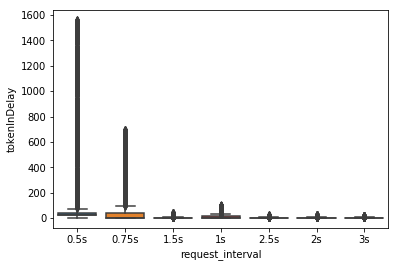

In [88]:
sns.boxplot('request_interval', 'tokenInDelay', data=end2end_delays)

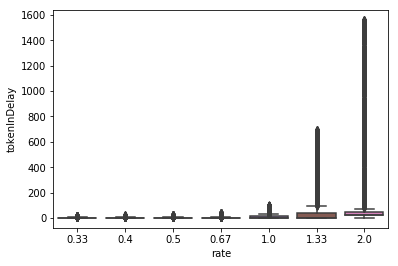

In [89]:
g = sns.boxplot('rate', 'tokenInDelay', data=end2end_delays)

fig = g.get_figure()
fig.savefig('plots/max-rate.pdf', bbox_inches='tight')

c:\users\stefan\git-repos\work\venv\qpn\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


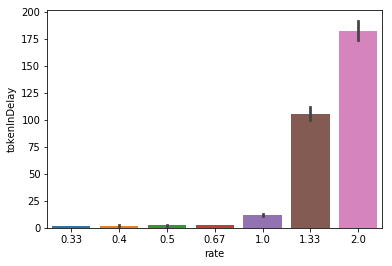

In [90]:
sns.barplot('rate', 'tokenInDelay', data=end2end_delays, estimator=mean)

c:\users\stefan\git-repos\work\venv\qpn\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


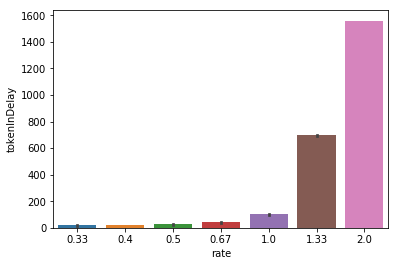

In [91]:
sns.barplot('rate', 'tokenInDelay', data=end2end_delays, estimator=max)

### Queue lengths
For different VNFs to identify the bottleneck

In [92]:
qlengths = vector_values(vecs, 'queueLength0', only_modules=['C_T0', 'S_T0', 'V_T0', 'A_T0', 'C_T3'])
qlengths.head()

,module,request_interval,rate,time,queueLength0
0,C_T3,0.5s,2.0,0.0,0.0
1,C_T3,0.5s,2.0,1.0,0.0
2,C_T3,0.5s,2.0,2.0,0.0
3,C_T3,0.5s,2.0,3.0,1.0
4,C_T3,0.5s,2.0,4.0,1.0


c:\users\stefan\git-repos\work\venv\qpn\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


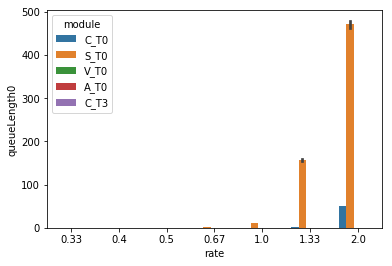

In [93]:
# mean queue length per request rate and module
sns.barplot('rate', 'queueLength0', hue='module', hue_order=['C_T0', 'S_T0', 'V_T0', 'A_T0', 'C_T3'], data=qlengths)

c:\users\stefan\git-repos\work\venv\qpn\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[(0, 12)]

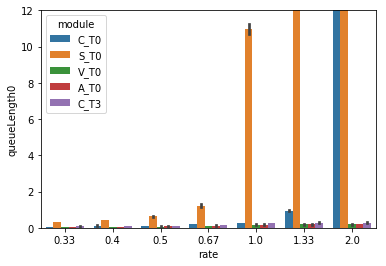

In [94]:
g = sns.barplot('rate', 'queueLength0', hue='module', hue_order=['C_T0', 'S_T0', 'V_T0', 'A_T0', 'C_T3'], data=qlengths)
g.set(ylim=(0, 12))

c:\users\stefan\git-repos\work\venv\qpn\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


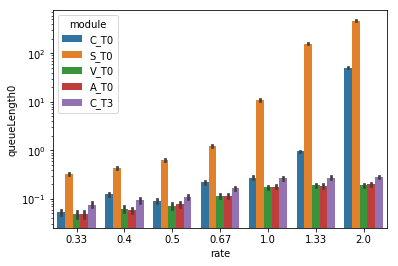

In [95]:
# log scale
g = sns.barplot('rate', 'queueLength0', hue='module', hue_order=['C_T0', 'S_T0', 'V_T0', 'A_T0', 'C_T3'], data=qlengths)
g.set(yscale='log')

fig = g.get_figure()
fig.savefig('plots/queue-length.pdf', bbox_inches='tight')